# Convolutional GAN

In [37]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cudnn.benchmark = True

In [3]:
#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  7490


In [4]:
#loading the dataset
dataset = dset.MNIST(root='./data', download=True,
                       transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))

In [102]:
dataset = dset.CIFAR10(root="./data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

Files already downloaded and verified


In [181]:
dataset = dset.CIFAR10(root='./data', 
                       download=False)
dataset = [dataset[i] for i in range(len(dataset)) if dataset[i][1] == 5]

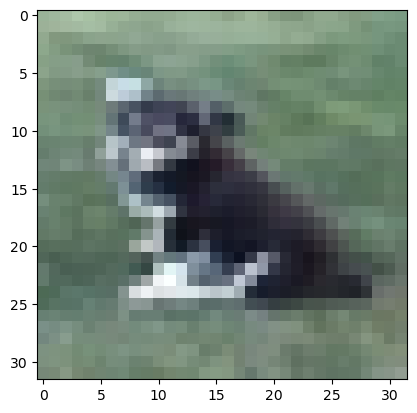

In [186]:
plt.imshow(dataset[4][0])

In [204]:
dataset = dset.CIFAR10(root='./data', 
                       download=False)
dataset = [dataset[i] for i in range(len(dataset)) if dataset[i][1] == 5]
preprocess = transforms.Compose([
               transforms.Resize(64),
               transforms.ToTensor(),
               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
           ])
dataset = [[preprocess(dataset[i][0]), dataset[i][1]] for i in range(len(dataset))]

In [205]:
#number of channels in image
nc=3

In [206]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                         shuffle=True, num_workers=2)

In [207]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [208]:
# number of gpu's available
ngpu = 1
# input noise dimension
nz = 100
# number of generator filters
ngf = 64
#number of discriminator filters
ndf = 64

In [222]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [223]:
class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [224]:
netG = Generator(ngpu, nc, nz, ngf).to(device)
netG.apply(weights_init)
#netG.load_state_dict(torch.load('weights/netG_epoch_99.pth'))
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [225]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [226]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#netD.load_state_dict(torch.load('weights/netD_epoch_99.pth'))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [227]:
criterion = nn.BCELoss()

In [228]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [229]:
fixed_noise = torch.randn(128, nz, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0

In [230]:
niter = 100

In [231]:
loss_g = []
loss_d = []
lossg = 0
lossd = 0

In [232]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        if i % 100 == 0:
            print(f'Loss_D: {errD.item()}  Loss_G: {errG.item()} D(x): {D_x} D(G(z)): {D_G_z1} / {D_G_z2}')
            loss_g.append(errG.item())
            loss_d.append(errD.item())
            #vutils.save_image(real_cpu,'./outputs/real_samples.png' ,normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),'./outputs/dog_fake_samples_epoch_%03d.png' % (epoch), normalize=True)
    print(f'Epoch: {epoch} out of {niter} complete')
    #torch.save(netG.state_dict(), 'weights/netG_epoch_%d.pth' % (epoch))
    #torch.save(netD.state_dict(), 'weights/netD_epoch_%d.pth' % (epoch))

Loss_D: 1.5805522203445435  Loss_G: 7.869336128234863 D(x): 0.680050253868103 D(G(z)): 0.5726128220558167 / 0.0005607826169580221
Loss_D: 0.6221687197685242  Loss_G: 5.644061088562012 D(x): 0.9325242638587952 D(G(z)): 0.3764753043651581 / 0.004138379357755184
Loss_D: 0.5820028185844421  Loss_G: 9.979595184326172 D(x): 0.9849900007247925 D(G(z)): 0.36471235752105713 / 6.561259215231985e-05
Loss_D: 0.12225093692541122  Loss_G: 6.64063835144043 D(x): 0.943336546421051 D(G(z)): 0.05020744353532791 / 0.0018964046612381935
Epoch: 0 out of 100 complete
Loss_D: 0.19870680570602417  Loss_G: 5.944869041442871 D(x): 0.9142229557037354 D(G(z)): 0.08825229853391647 / 0.0033634300343692303
Loss_D: 0.34560126066207886  Loss_G: 2.437833309173584 D(x): 0.7619221210479736 D(G(z)): 0.012931185774505138 / 0.11678323894739151
Loss_D: 0.07484298199415207  Loss_G: 6.515924453735352 D(x): 0.9542012810707092 D(G(z)): 0.021865220740437508 / 0.006077836733311415
Loss_D: 0.6496132612228394  Loss_G: 2.856599807739

Epoch: 14 out of 100 complete
Loss_D: 1.1459330320358276  Loss_G: 5.243200778961182 D(x): 0.9626423120498657 D(G(z)): 0.5845201015472412 / 0.00727139413356781
Loss_D: 0.21641668677330017  Loss_G: 4.970944404602051 D(x): 0.9850316643714905 D(G(z)): 0.17107194662094116 / 0.008419820107519627
Loss_D: 0.9549823999404907  Loss_G: 4.9086079597473145 D(x): 0.8006856441497803 D(G(z)): 0.4669773578643799 / 0.008320745080709457
Loss_D: 0.511294424533844  Loss_G: 4.938070774078369 D(x): 0.9325911998748779 D(G(z)): 0.32281529903411865 / 0.008124860934913158
Epoch: 15 out of 100 complete
Loss_D: 0.4368404746055603  Loss_G: 4.631350517272949 D(x): 0.9586943984031677 D(G(z)): 0.28850066661834717 / 0.013910012319684029
Loss_D: 0.13585466146469116  Loss_G: 4.29652214050293 D(x): 0.9867863655090332 D(G(z)): 0.11267884075641632 / 0.01636730507016182
Loss_D: 1.3770874738693237  Loss_G: 2.98673415184021 D(x): 0.7340096831321716 D(G(z)): 0.5328748226165771 / 0.07263047993183136
Loss_D: 0.8634941577911377  L

Epoch: 29 out of 100 complete
Loss_D: 0.09867917746305466  Loss_G: 5.097743988037109 D(x): 0.9465985298156738 D(G(z)): 0.03849288076162338 / 0.012385593727231026
Loss_D: 1.032857894897461  Loss_G: 1.457978367805481 D(x): 0.7871959805488586 D(G(z)): 0.44877564907073975 / 0.2873433828353882
Loss_D: 0.2614278793334961  Loss_G: 3.7282819747924805 D(x): 0.921069860458374 D(G(z)): 0.15078218281269073 / 0.029269814491271973
Loss_D: 0.8491054177284241  Loss_G: 1.157431960105896 D(x): 0.5343822240829468 D(G(z)): 0.11485117673873901 / 0.36772584915161133
Epoch: 30 out of 100 complete
Loss_D: 0.7023736238479614  Loss_G: 3.609828233718872 D(x): 0.8779149651527405 D(G(z)): 0.3464219570159912 / 0.03408604860305786
Loss_D: 0.0437140166759491  Loss_G: 4.363560676574707 D(x): 0.9772140383720398 D(G(z)): 0.02022625505924225 / 0.014651758596301079
Loss_D: 0.04763137921690941  Loss_G: 5.424288272857666 D(x): 0.9579669237136841 D(G(z)): 0.003991996869444847 / 0.005513903684914112
Loss_D: 2.781656503677368 

Epoch: 44 out of 100 complete
Loss_D: 1.0397151708602905  Loss_G: 2.403256416320801 D(x): 0.5192862749099731 D(G(z)): 0.10631261020898819 / 0.12552803754806519
Loss_D: 0.1392645686864853  Loss_G: 4.657397270202637 D(x): 0.9852204918861389 D(G(z)): 0.09311702847480774 / 0.01840094104409218
Loss_D: 0.0810086652636528  Loss_G: 4.474431037902832 D(x): 0.9963438510894775 D(G(z)): 0.07192271947860718 / 0.018221082165837288
Loss_D: 0.23513025045394897  Loss_G: 3.5821330547332764 D(x): 0.9087117910385132 D(G(z)): 0.1159311830997467 / 0.03886200487613678
Epoch: 45 out of 100 complete
Loss_D: 0.20927365124225616  Loss_G: 3.973799705505371 D(x): 0.9963037967681885 D(G(z)): 0.1722317636013031 / 0.026537500321865082
Loss_D: 0.19760601222515106  Loss_G: 4.765927314758301 D(x): 0.9991350769996643 D(G(z)): 0.12967093288898468 / 0.011979702860116959
Loss_D: 0.09374421834945679  Loss_G: 4.682087421417236 D(x): 0.9266533851623535 D(G(z)): 0.014652607031166553 / 0.015176019631326199
Loss_D: 0.024409592151

Loss_D: 0.024311715736985207  Loss_G: 7.998168468475342 D(x): 0.9773311614990234 D(G(z)): 0.000965250248555094 / 0.001065923017449677
Epoch: 59 out of 100 complete
Loss_D: 0.053266216069459915  Loss_G: 6.52730655670166 D(x): 0.9534242749214172 D(G(z)): 0.0019844877533614635 / 0.0035947291180491447
Loss_D: 0.7711660861968994  Loss_G: 1.7726130485534668 D(x): 0.5602920055389404 D(G(z)): 0.0367598719894886 / 0.23623235523700714
Loss_D: 0.1484956443309784  Loss_G: 3.6307895183563232 D(x): 0.9242973327636719 D(G(z)): 0.05840253084897995 / 0.04504350572824478
Loss_D: 0.5023082494735718  Loss_G: 5.114895343780518 D(x): 0.9578309059143066 D(G(z)): 0.2696462869644165 / 0.009907943196594715
Epoch: 60 out of 100 complete
Loss_D: 0.4935370087623596  Loss_G: 2.772660493850708 D(x): 0.9152522683143616 D(G(z)): 0.28459081053733826 / 0.07531572133302689
Loss_D: 0.5139014720916748  Loss_G: 3.4508049488067627 D(x): 0.8612127304077148 D(G(z)): 0.22483915090560913 / 0.06248927116394043
Loss_D: 0.435779839

Loss_D: 0.04787246137857437  Loss_G: 4.588233947753906 D(x): 0.98291015625 D(G(z)): 0.029026377946138382 / 0.015284440480172634
Loss_D: 0.597713053226471  Loss_G: 5.952497959136963 D(x): 0.9963845610618591 D(G(z)): 0.3859754204750061 / 0.0034862137399613857
Epoch: 74 out of 100 complete
Loss_D: 1.3932417631149292  Loss_G: 7.335810661315918 D(x): 0.9028826951980591 D(G(z)): 0.5714538097381592 / 0.0010431557893753052
Loss_D: 0.04670526832342148  Loss_G: 6.068206310272217 D(x): 0.9901270866394043 D(G(z)): 0.03361058980226517 / 0.007159488741308451
Loss_D: 0.18626755475997925  Loss_G: 3.079669952392578 D(x): 0.9574097990989685 D(G(z)): 0.11890745162963867 / 0.0623454675078392
Loss_D: 0.06535027921199799  Loss_G: 4.641566753387451 D(x): 0.9760480523109436 D(G(z)): 0.03921860083937645 / 0.016816578805446625
Epoch: 75 out of 100 complete
Loss_D: 0.430257648229599  Loss_G: 4.73275089263916 D(x): 0.6871936321258545 D(G(z)): 0.014203395694494247 / 0.016140837222337723
Loss_D: 0.03323807194828987

Loss_D: 0.0018373038619756699  Loss_G: 7.549784183502197 D(x): 0.9995377063751221 D(G(z)): 0.0013727513141930103 / 0.000798978260718286
Loss_D: 0.004380077589303255  Loss_G: 7.027704238891602 D(x): 0.999759316444397 D(G(z)): 0.004127522464841604 / 0.0011595995165407658
Loss_D: 2.6090274332091212e-05  Loss_G: 48.32542419433594 D(x): 0.9999738931655884 D(G(z)): 4.445329600274275e-21 / 4.448401639209372e-21
Epoch: 89 out of 100 complete
Loss_D: 4.5410008169710636e-05  Loss_G: 48.49039077758789 D(x): 0.9999545812606812 D(G(z)): 8.591366029439972e-21 / 8.623216521991098e-21
Loss_D: 0.0001049306956701912  Loss_G: 47.789794921875 D(x): 0.9998950958251953 D(G(z)): 2.1017353970568248e-20 / 2.1037606970878726e-20
Loss_D: 1.3262060747365467e-06  Loss_G: 48.361297607421875 D(x): 0.9999986886978149 D(G(z)): 1.8635411868023295e-21 / 1.8640462597300627e-21
Loss_D: 8.545950549887493e-06  Loss_G: 47.987831115722656 D(x): 0.9999914169311523 D(G(z)): 3.465572534899644e-21 / 3.46585930161591e-21
Epoch: 90

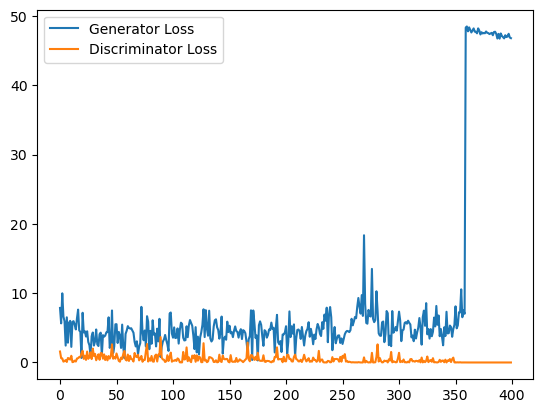

In [236]:
plt.plot(loss_g, label='Generator Loss')
plt.plot(loss_d, label='Discriminator Loss')
plt.legend()
plt.show()